In [1]:
import pandas as pd
import sqlite3
import numpy as np

Запрос: объединяем две таблицы: Trading_session остортированная по времени и Chart_data, где убраны повторяющиеся deal_id и также отсортированная по времени.

In [2]:
con = sqlite3.connect('trade_info.sqlite3')
query = """SELECT *
FROM (SELECT *
        FROM Trading_session 
        ORDER BY date) AS A
JOIN (SELECT * 
        FROM Chart_data 
        GROUP BY deal_id 
        ORDER BY time) AS B
ON A.id=B.session_id"""
data = pd.read_sql(query, con)

Объединим дату и время

In [3]:
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

Нормируем цену

In [4]:
data["norm_price"] = data.groupby("session_id")["price"].transform(lambda x: (x - x.mean()) / x.std()).fillna(0)

In [5]:
data

,id,date,trading_type,platform_id,id,time,lot_size,session_id,deal_id,price,datetime,norm_price
0,35,2019-02-21,monthly,1,1114,11:05:02,1,35,688,-0.735466,2019-02-21 11:05:02,0.000000
1,36,2019-02-21,monthly,2,1115,11:05:02,1,36,689,-1.129379,2019-02-21 11:05:02,0.000000
2,39,2019-03-22,monthly,1,926,11:05:02,17,39,647,-0.765767,2019-03-22 11:05:02,1.688904
3,39,2019-03-22,monthly,1,927,11:05:02,16,39,648,-0.765767,2019-03-22 11:05:02,1.688904
4,39,2019-03-22,monthly,1,928,11:05:02,4,39,649,-0.765767,2019-03-22 11:05:02,1.688904
...,...,...,...,...,...,...,...,...,...,...,...,...
4604,278,2021-06-23,monthly,2,5503,12:59:21,15,278,4611,1.946171,2021-06-23 12:59:21,-1.128766
4605,279,2021-06-24,daily,1,5504,11:01:06,179,279,4612,1.128045,2021-06-24 11:01:06,0.000000
4606,279,2021-06-24,daily,1,5505,11:01:06,300,279,4613,1.128045,2021-06-24 11:01:06,0.000000
4607,279,2021-06-24,daily,1,5506,11:01:06,20,279,4614,1.128045,2021-06-24 11:01:06,0.000000


Визуализация и построение кластеров

In [6]:
from trade import prepare_data
from build_cluster import cluster_plot_kmeans, cluster_plot_kernel_kmeans

/home/artosim/anaconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [7]:
X_train = prepare_data(data)

In [8]:
X_train.shape

(256, 60, 1)

Eucledian KMeans


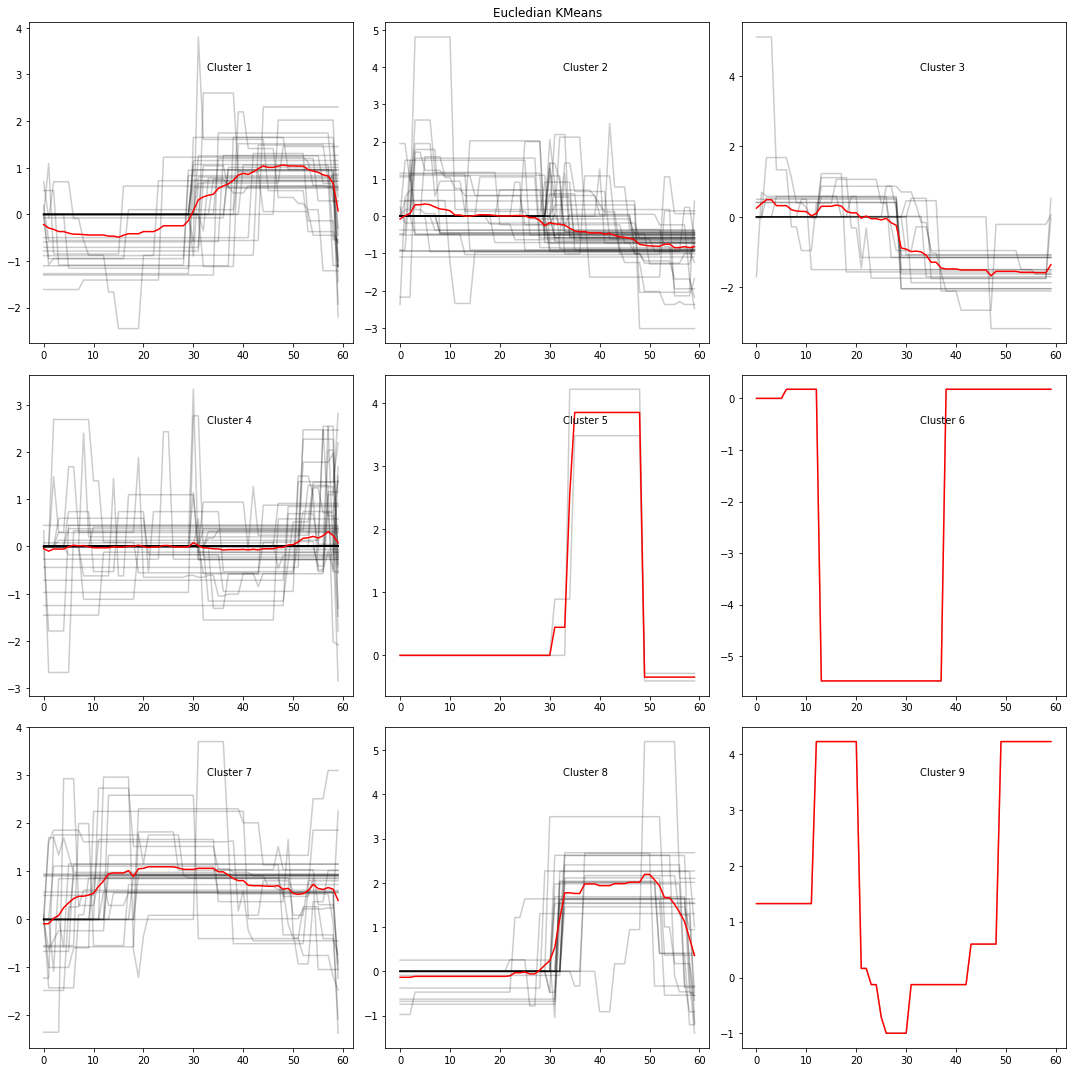

In [14]:
cluster_plot_kmeans(X_train, 9, 'euclidean', 'Eucledian KMeans')

DTW KMeans


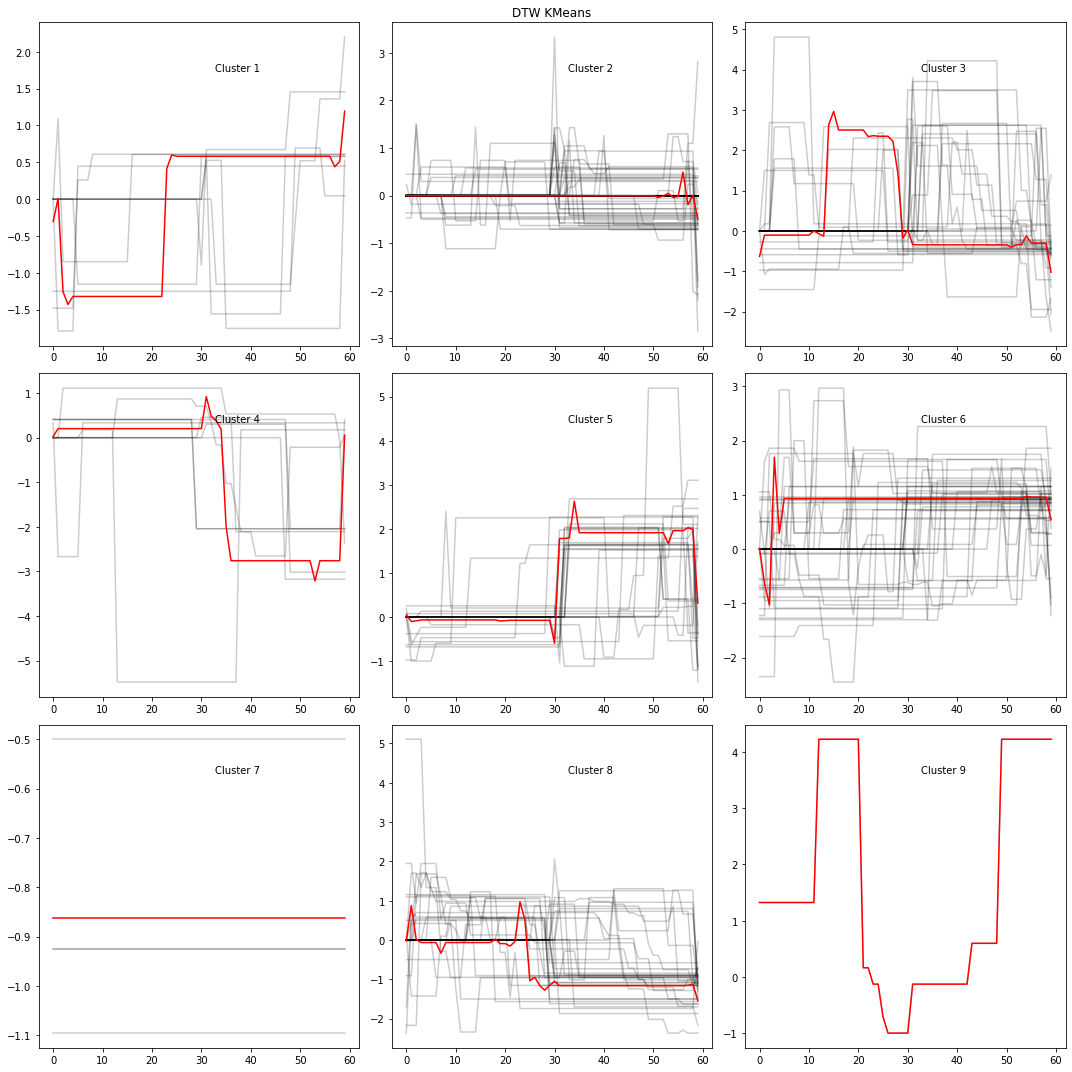

In [16]:
cluster_plot_kmeans(X_train, 9, 'dtw', 'DTW KMeans')

Cosine Kernel KMeans


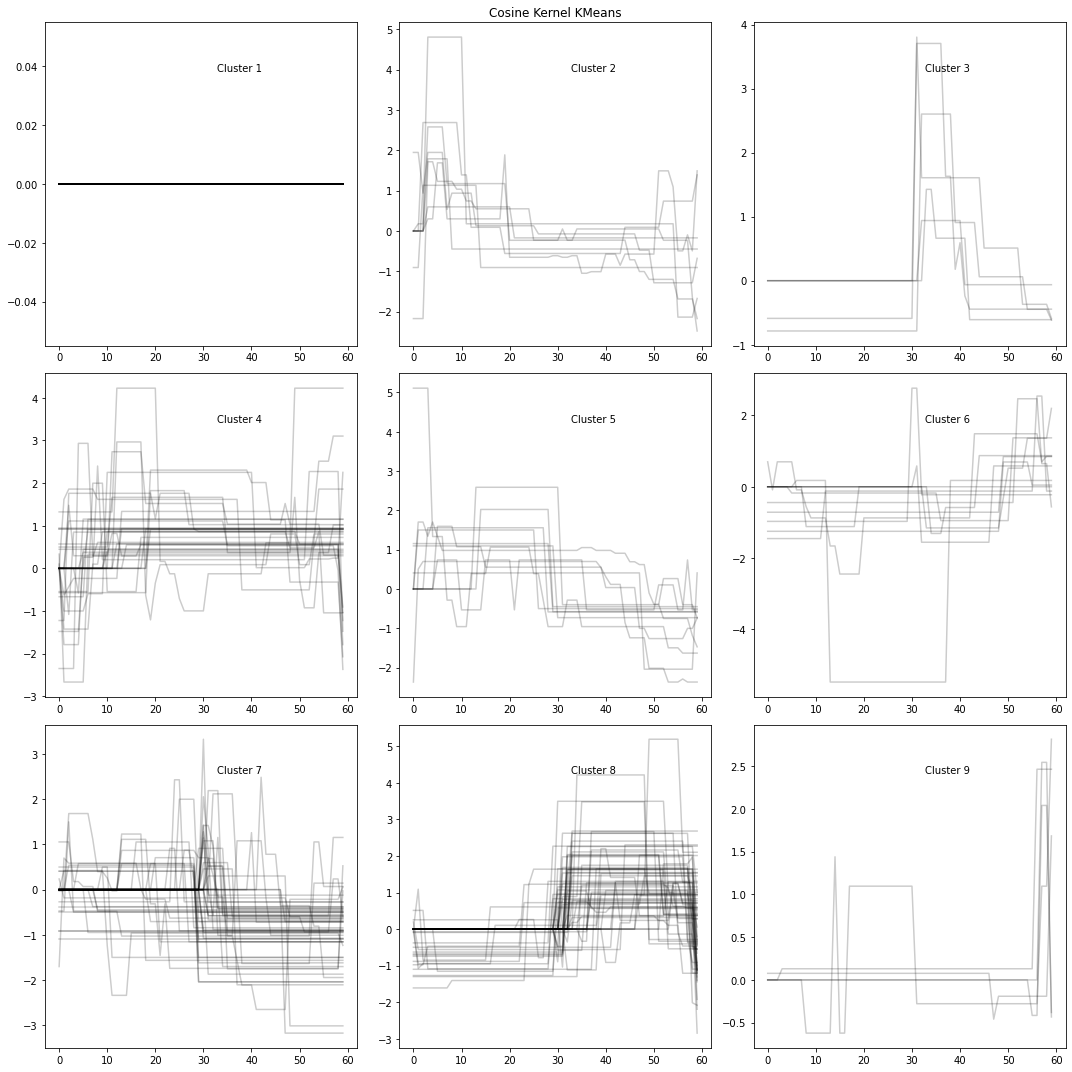

In [15]:
cluster_plot_kernel_kmeans(X_train, 9, 'cosine', 'Cosine Kernel KMeans')

Результаты: был проведен кластерный анализ из которого можно сказать, что на рынке есть похожие паттерны сессии. Но на сколько сильно он может помочь в реальных торгах? Посмотрим на кластер 3, полученный с помощью косинусного расстрояния. Можно увижеть, что если цена скакнула сильно вверх, то нужно подождать, и почти всегда цена возвращается к прежднему значению. Или кластер 1 на графиках "Eucledian KMeans", тоже может говорить, нам о том, что если цена плавно уменьшается, а затем к середине торгов возвращается к первоначальной отметке, то и в ближайшие 15 минут, она также будет расти.
Почему вообще есть схожие паттерны? Во первых, это сезонность, как мы обсуждали на паре, то некоторые скачки повторяются с лагом в год. Возможно каждый год, одна компания покупает сразу большой объем сырья одним махом, что становится причиной резкого увеличения цены. Такие компании образуют похожие паттерны. Во вторых, можем заметить, что довольно часто к концу торгов цена уменьшается. Данные торги сильно специфичные и идут по часу, и такая динамика показывает, что продавцы сырья уменьшают цену в пределах разумного, чтобы продать лишний объем. Все таки хранить сырье тоже где-то надо, и пока будут ждать момента, чтобы продать по высокой цене, добыча может остановиться из-за переполнения складов.
Я вижу, что кластерным анализом можно попыпаться предсказать примерное движение цены, но полностью пологаться на него не стоит.